In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import joblib
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve
from sklearn.tree import export_text, plot_tree
import joblib
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from sklearn.tree import _tree


In [9]:
# Load the data
df = pd.read_csv('./data/train_data.csv')
df.head(2)

,offer expiration,income_range,no_visited_Cold drinks,travelled_more_than_15mins_for_offer,Restaur_spend_less_than20,Marital Status,restaurant type,age,Prefer western over chinese,travelled_more_than_25mins_for_offer,...,restuarant_opposite_direction_house,has Children,visit restaurant with rating (avg),temperature,Restaur_spend_greater_than20,Travel Time,Climate,drop location,Prefer home food,Offer Accepted
0,2days,₹100000 or More,4~8,1,less1,Married partner,4 star restaurant,36,0,0,...,0,0,4,67,less1,22,Spring,Location B,0,No
1,2days,₹87500 - ₹99999,4~8,0,4~8,Married partner,Take-away restaurant,50plus,0,0,...,0,1,3,89,1~3,18,Summer,Location B,0,Yes


In [10]:
def separate_columns(df):
    # Separate numerical and categorical columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = df.select_dtypes(include=[object]).columns.tolist()

    # Further separate categorical columns into binary and multi-category columns
    binary_cols = [col for col in categorical_cols if df[col].nunique() == 2]
    multi_cols = [col for col in categorical_cols if df[col].nunique() > 2]

    return numeric_cols, categorical_cols, binary_cols, multi_cols


In [11]:
# Split the dataset into features and target variable
X = df.drop('Offer Accepted', axis=1)
y = df['Offer Accepted'].replace({'Yes': 1, 'No': 0})
numeric_cols, categorical_cols, binary_cols, multi_cols = separate_columns(X)
# Split the dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [13]:
# Define the preprocessing steps for both types of features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('scaler', StandardScaler())])

binary_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='missing')),
    ('ordinalencoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))])

# Group the preprocessing steps together
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols),
        ('binary', binary_transformer, binary_cols)
    ]
)


In [14]:
# Define the models
models = [
    ('rf', RandomForestClassifier()), 
    ('dt', DecisionTreeClassifier()),
    ('gb', GradientBoostingClassifier()),
    ('xgb', XGBClassifier()),
]


In [15]:
# Define the pipelines
pipelines = []
for name, model in models:
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                          (name, model)])
    pipelines.append((name, clf))
print(pipelines[0][1][1])

RandomForestClassifier()


In [16]:
def plot_confusion_matrix(y_true, y_pred, model_name):
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.savefig(f'./experiment-store/{model_name}_confusion_matrix.png')
    plt.close()
def plot_roc_curve(y_true, y_prob, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    auc = roc_auc_score(y_true, y_prob)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.title('ROC Curve')
    plt.savefig(f'./experiment-store/{model_name}_roc_curve.png')
    plt.close()
def plot_precision_recall_curve(y_true, y_prob, model_name):
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    plt.figure(figsize=(6, 4))
    plt.plot(recall, precision)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.savefig(f'./experiment-store/{model_name}_precision_recall_curve.png')
    plt.close()


In [9]:
# Train the models and evaluate
model_performance = []
for name, pipeline in pipelines:
    print(f"----------------{name}--------------")
    # Fit the pipeline on the training data
    model = pipeline.fit(X_train, y_train)

    # Predict on the test data
    y_pred = model.predict(X_test)

    # Compute metrics of the model
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    confusion = confusion_matrix(y_test, y_pred)

    # Store the metrics and model parameters
    model_performance.append({
        'modelname': name, 
        'accuracy': accuracy, 
        'precision': precision, 
        'recall': recall, 
        'f1_score': f1, 
        'confusion_matrix': confusion,
        'parameters': model.get_params()
    })
    # Save the best model as a .pkl file
    model_filename = f"./experiment-store/{name}-model.pkl"
    os.makedirs('./experiment-store', exist_ok=True)
    joblib.dump(model, model_filename)
    print(f"Saved {name} model to {model_filename}")
    
    # os.makedirs('./plots', exist_ok=True)
    
    y_prob = model.predict_proba(X_test)[:, 1]
    model_name = name
    plot_confusion_matrix(y_test, y_pred, model_name)
    plot_roc_curve(y_test, y_prob, model_name)
    plot_precision_recall_curve(y_test, y_prob, model_name)
    print()

# Create DataFrame from the model performance data
df_performance = pd.DataFrame(model_performance)

perf_dir = "./experiment-store"
# Create directories if they do not exist
os.makedirs(perf_dir, exist_ok=True)
# Save DataFrame to an Excel file
df_performance.to_excel("./experiment-store/initial-model-performance.xlsx")


----------------rf--------------


Saved rf model to ./experiment-store/rf-model.pkl

----------------dt--------------
Saved dt model to ./experiment-store/dt-model.pkl

----------------gb--------------
Saved gb model to ./experiment-store/gb-model.pkl

----------------xgb--------------
Saved xgb model to ./experiment-store/xgb-model.pkl



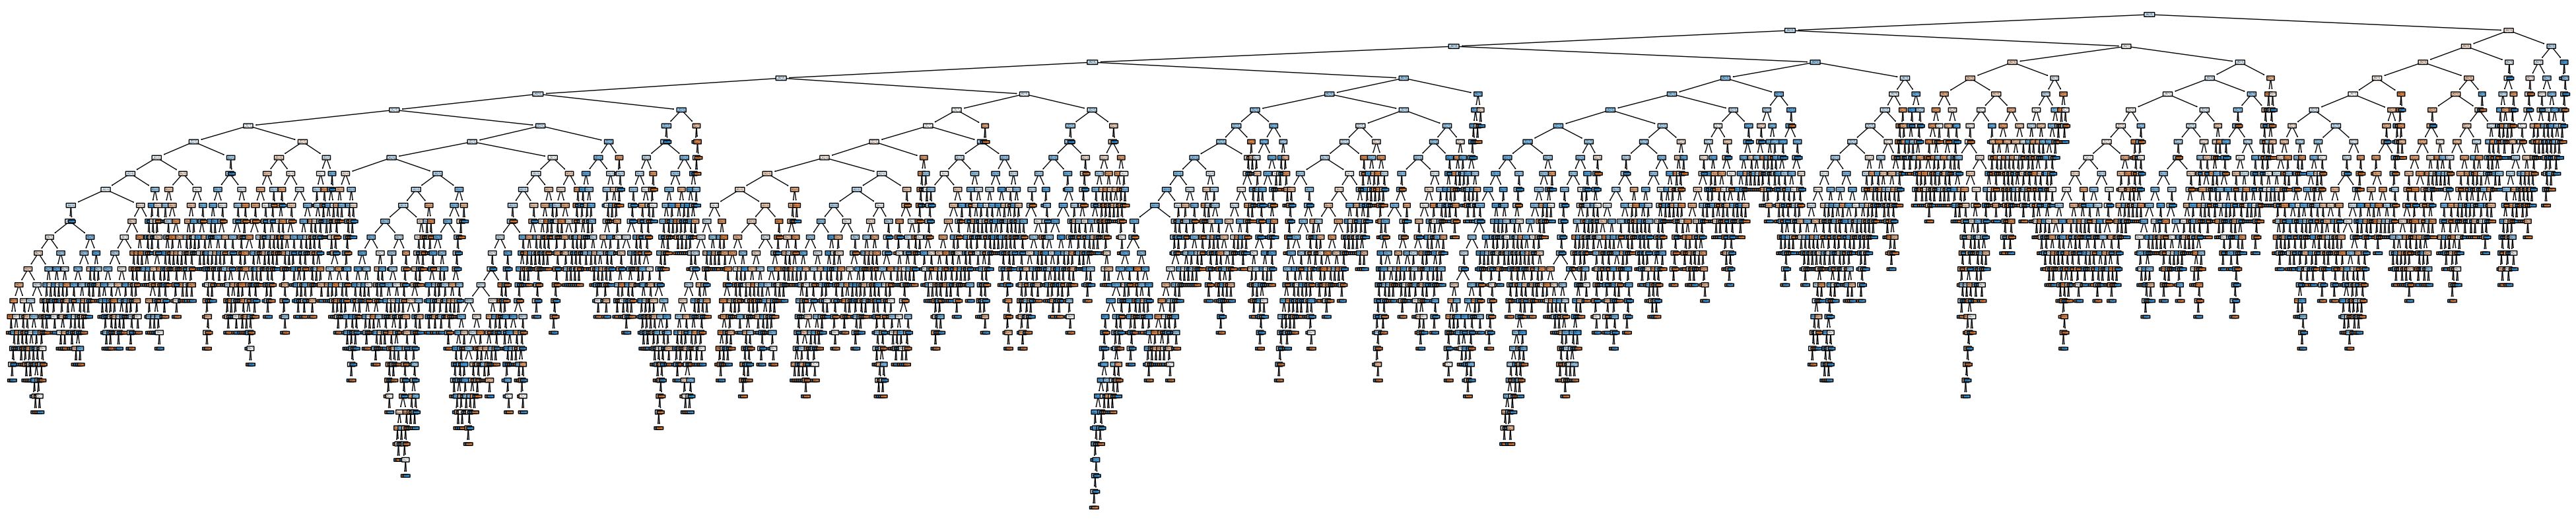

In [10]:
model_path = './experiment-store/rf-model.pkl'
pipeline = joblib.load(model_path)

model = pipeline.named_steps['rf']
tree_model = model.estimators_[0]

# Plot the tree
plt.figure(figsize=(50, 10))
### plot_tree(tree_model, feature_names=list_of_feature_names, filled=True, rounded=True, class_names=True)
plot_tree(tree_model, filled=True, rounded=True)
plt.savefig('./experiment-store/tree_visualization.png', dpi=700)
plt.show()


In [11]:
def extract_tree_structure(tree, feature_names):
    # Initialize an empty dataframe to store the tree structure
    df = pd.DataFrame(columns=['node_id', 'feature', 'threshold', 'left_child', 'right_child'])

    # Recursive function to visit each node and extract information
    def recurse(node_id):
        # If we're at a leaf node (no children), return
        if tree.children_left[node_id] == _tree.TREE_LEAF:
            return

        # Extract feature name, threshold, and children from the tree
        feature = feature_names[tree.feature[node_id]]
        threshold = tree.threshold[node_id]
        left_child = tree.children_left[node_id]
        right_child = tree.children_right[node_id]

        # Append the node information to the dataframe
        df.loc[node_id] = [node_id, feature, threshold, left_child, right_child]
        # Recurse on the children of the node
        recurse(left_child)
        recurse(right_child)
    # Start recursion from the root of the tree (node 0)
    recurse(0)
    return df

# Call the function on your tree
tree = model.estimators_[0].tree_
# feature_names = X_train.columns
# df_tree_structure = extract_tree_structure(tree, feature_names)

# Get the preprocessor from the pipeline
preprocessor = pipeline.named_steps['preprocessor']
# Get the transformed feature names
transformed_feature_names = preprocessor.get_feature_names_out(input_features=X_train.columns)
# Use the transformed feature names when extracting the tree structure
df_tree_structure = extract_tree_structure(tree, transformed_feature_names)


# Save the dataframe to an Excel file
df_tree_structure.to_excel('./experiment-store/tree_structure.xlsx')


In [18]:
import shap

# Specify the model name
modelname = "gb"

# Load the pipeline
model_path = f'./experiment-store/{modelname}-model.pkl'
pipeline = joblib.load(model_path)

# Get the model from the pipeline
model = pipeline.named_steps[modelname]

# Get the preprocessor from the pipeline
preprocessor = pipeline.named_steps['preprocessor']

# Transform the training data
X_train_transformed = preprocessor.transform(X_train)

# Convert the transformed data into a DataFrame
transformed_feature_names = preprocessor.get_feature_names_out(input_features=X_train.columns)
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=transformed_feature_names)

# Create an explainer
explainer = shap.TreeExplainer(model)

# Compute SHAP values
shap_values = explainer.shap_values(X_train_transformed_df)

# Initialize JavaScript visualization code
shap.initjs()

# # Check the dimension of the SHAP values array
# if len(shap_values.shape) == 2:
#     # Visualize the SHAP values for the first instance in the training set
#     shap.force_plot(explainer.expected_value[0], shap_values[0,:], X_train_transformed_df.iloc[0,:])
# else:
#     # Visualize the SHAP values for the first instance in the training set
#     shap.force_plot(explainer.expected_value, shap_values[0,:], X_train_transformed_df.iloc[0,:])

# Check the dimension of the SHAP values array
if len(shap_values.shape) == 2:
    # Visualize the SHAP values for the first instance in the training set
    shap.force_plot(explainer.expected_value[0], shap_values[0,:], X_train_transformed_df.iloc[0,:], show=False, matplotlib=True).savefig('./experiment-store/shap_plot.png')
else:
    # Visualize the SHAP values for the first instance in the training set
    shap.force_plot(explainer.expected_value, shap_values[0,:], X_train_transformed_df.iloc[0,:], show=False, matplotlib=True).savefig('./experiment-store/shap_plot.png')


In [20]:
# # Convert the SHAP values to a DataFrame
# shap_values_df = pd.DataFrame(shap_values, columns=X_train_transformed_df.columns)

# # Add a column for the base value
# shap_values_df['BASE VALUE'] = explainer.expected_value

# # Save to an Excel file
# shap_values_df.to_excel('./experiment-store/shap_values.xlsx')


# Convert the SHAP values to a DataFrame
shap_values_df = pd.DataFrame(shap_values, columns=X_train_transformed_df.columns)

# Save to an Excel file
shap_values_df.to_excel('./experiment-store/shap_values.xlsx')

# Print the base value
print('Base value:', explainer.expected_value)


Base value: [0.28683339]


In [5]:
# Path to the model pickle file
model_path = './experiment-store/gb-model.pkl'

# Loading the trained model
model = joblib.load(model_path)

# Extracting the columns (excluding the target variable)
columns = df.columns[:-1]

# Creating an empty DataFrame with the same columns
input_data = pd.DataFrame(columns=columns)

# Known values
known_values = {'offer expiration': '-1',
 'income_range': '-1',
 'no_visited_Cold drinks': '-1',
 'travelled_more_than_15mins_for_offer': -1,
 'Restaur_spend_less_than20': '-1',
 'Marital Status': '-1',
 'restaurant type': '-1',
 'age': '-1',
 'Prefer western over chinese': -1,
 'travelled_more_than_25mins_for_offer': -1,
 'travelled_more_than_5mins_for_offer': -1,
 'no_visited_bars': '-1',
 'gender': '-1',
 'car': "-1",
 'restuarant_same_direction_house': -1,
 'Cooks regularly': -1,
 'Customer type': '-1',
 'Qualification': '-1',
 'is foodie': -1,
 'no_Take-aways': '-1',
 'Job/Job Industry': '-1',
 'restuarant_opposite_direction_house': -1,
 'has Children': -1,
 'visit restaurant with rating (avg)': -1,
 'temperature': -1,
 'Restaur_spend_greater_than20': '-1',
 'Travel Time': -1,
 'Climate': '-1',
 'drop location': '-1',
 'Prefer home food': -1}

# Inserting a new row with known values and keeping other columns as null
input_data.loc[0] = [known_values.get(col, np.nan) for col in columns]

# Making a prediction based on the input data
prediction_result = model.predict(input_data)
prediction_result[0]


1

In [29]:
testdf = pd.read_csv('./data/test.csv')
# testdf = testdf.drop('Offer Accepted')
testdf.head(2)

,offer expiration,income_range,no_visited_Cold drinks,travelled_more_than_15mins_for_offer,Restaur_spend_less_than20,Marital Status,restaurant type,age,Prefer western over chinese,travelled_more_than_25mins_for_offer,...,restuarant_opposite_direction_house,has Children,visit restaurant with rating (avg),temperature,Restaur_spend_greater_than20,Travel Time,Climate,drop location,Prefer home food,Offer Accepted
0,2days,â‚¹37500 - â‚¹49999,never,0,1~3,Unmarried partner,Cold drinks,50plus,0,0,...,1,1,4,67,less1,14,Summer,Location C,0,No
1,2days,â‚¹37500 - â‚¹49999,1~3,1,1~3,Married partner,Restaurant with pub,26,0,0,...,1,0,2,40,1~3,22,Spring,Location A,1,Yes


In [30]:
X_ftest = testdf.drop('Offer Accepted', axis=1)
y_ftest = testdf['Offer Accepted'].replace({'Yes': 1, 'No': 0})


In [31]:
# Path to the model pickle file
model_path = './experiment-store/gb-model.pkl'

# Loading the trained model
model = joblib.load(model_path)

# Extracting the columns (excluding the target variable)
columns = df.columns[:-1]

In [32]:
# Predict on the test data
y_fpred = model.predict(X_ftest)
y_fpred

array([0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1], dtype=int64)

In [33]:
len([y_fpred][0])

12

In [34]:
model_performance = []
# Compute metrics of the model
accuracy = accuracy_score(y_ftest, y_fpred)
precision = precision_score(y_ftest, y_fpred, average='weighted')
recall = recall_score(y_ftest, y_fpred, average='weighted')
f1 = f1_score(y_ftest, y_fpred, average='weighted')
confusion = confusion_matrix(y_ftest, y_fpred)
# Store the metrics and model parameters
model_performance.append({
    'modelname': name, 
    'accuracy': accuracy, 
    'precision': precision, 
    'recall': recall, 
    'f1_score': f1, 
    'confusion_matrix': confusion,
    'parameters': model.get_params()
})
df_performance = pd.DataFrame(model_performance)
df_performance

,modelname,accuracy,precision,recall,f1_score,confusion_matrix,parameters
0,xgb,0.666667,0.666667,0.666667,0.666667,"[[4, 2], [2, 4]]","{'memory': None, 'steps': [('preprocessor', Co..."


In [47]:
d = X_ftest.tail(2).head(1)
# d = X_ftest.tail(2).head(1).to_dict()
d

,offer expiration,income_range,no_visited_Cold drinks,travelled_more_than_15mins_for_offer,Restaur_spend_less_than20,Marital Status,restaurant type,age,Prefer western over chinese,travelled_more_than_25mins_for_offer,...,Job/Job Industry,restuarant_opposite_direction_house,has Children,visit restaurant with rating (avg),temperature,Restaur_spend_greater_than20,Travel Time,Climate,drop location,Prefer home food
10,2days,â‚¹12500 - â‚¹24999,less1,1,4~8,Married partner,Cold drinks,26,1,0,...,Management,1,0,4,67,never,7,Summer,Location C,1


In [52]:
# Path to the model pickle file
model_path = './experiment-store/gb-model.pkl'

# Loading the trained model
model = joblib.load(model_path)

# Extracting the columns (excluding the target variable)
columns = df.columns[:-1]

# Creating an empty DataFrame with the same columns
input_data = pd.DataFrame(columns=columns)

# Known values
known_values = {
    'offer expiration': '2days',
    'income_range': '₹12500 - ₹24999',
    'no_visited_Cold drinks': 'less1',
    'travelled_more_than_15mins_for_offer': 1,
    'Restaur_spend_less_than20': '4~8',
    'Marital Status': 'Married partner',
    'restaurant type': 'Cold drinks',
    'age': 26,
    'Prefer western over chinese': 1,
    'travelled_more_than_25mins_for_offer': 0,
    'travelled_more_than_5mins_for_offer': 1,
    'no_visited_bars': 'never',
    'gender': 'Female',
    'car': '',
    'restuarant_same_direction_house': 0,
    'Cooks regularly': 1,
    'Customer type': 'Individual',
    'Qualification': 'Associates degree',
    'is foodie': 1,
    'no_Take-aways': 'gt8',
    'Job/Job Industry': 'Management',
    'restuarant_opposite_direction_house': 1,
    'has Children': 0,
    'visit restaurant with rating (avg)': 4,
    'temperature': 67,
    'Restaur_spend_greater_than20': 'never',
    'Travel Time': 7,
    'Climate': 'Summer',
    'drop location': 'Location C',
    'Prefer home food': 1
}


# Inserting a new row with known values and keeping other columns as null
input_data.loc[0] = [known_values.get(col, np.nan) for col in columns]

# Making a prediction based on the input data
prediction_result = model.predict(input_data)
prediction_result[0]


0

In [55]:
# Path to the model pickle file
model_path = './experiment-store/gb-model.pkl'

# Loading the trained model
model = joblib.load(model_path)

# Extracting the columns (excluding the target variable)
columns = df.columns[:-1]

# Creating an empty DataFrame with the same columns
input_data = pd.DataFrame(columns=columns)

# Known values
known_values = {
    'offer expiration': '10hours',
    'income_range': '₹25000 - ₹37499',
    'no_visited_Cold drinks': 'less1',
    'travelled_more_than_15mins_for_offer': 1,
    'Restaur_spend_less_than20': '4~8',
    'Marital Status': 'Single',
    'restaurant type': 'Take-away restaurant',
    'age': 26,
    'Prefer western over chinese': 0,
    'travelled_more_than_25mins_for_offer': 0,
    'travelled_more_than_5mins_for_offer': 1,
    'no_visited_bars': 'never',
    'gender': 'Female',
    'car': '',
    'restuarant_same_direction_house': 0,
    'Cooks regularly': 0,
    'Customer type': 'Individual',
    'Qualification': 'Bachelors degree',
    'is foodie': 0,
    'no_Take-aways': '1~3',
    'Job/Job Industry': 'Unemployed',
    'restuarant_opposite_direction_house': 1,
    'has Children': 0,
    'visit restaurant with rating (avg)': 2,
    'temperature': 89,
    'Restaur_spend_greater_than20': 'never',
    'Travel Time': 7,
    'Climate': 'Winter',
    'drop location': 'Location C',
    'Prefer home food': 1
}



# Inserting a new row with known values and keeping other columns as null
input_data.loc[0] = [known_values.get(col, np.nan) for col in columns]

# Making a prediction based on the input data
prediction_result = model.predict(input_data)
prediction_result[0]


1

In [107]:
# Path to the model pickle file
model_path = './experiment-store/gb-model.pkl'

# Loading the trained model
model = joblib.load(model_path)

# Extracting the columns (excluding the target variable)
columns = df.columns[:-1]

# Creating an empty DataFrame with the same columns
input_data = pd.DataFrame(columns=columns)

# Known values
known_values = {
    'offer expiration': '10hours',
    'income_range': '₹50000 - ₹62499',
    'no_visited_Cold drinks': 'never',
    'travelled_more_than_15mins_for_offer': 1,
    'Restaur_spend_less_than20': '',
    'Marital Status': 'Unmarried partner',
    'restaurant type': '2 star restaurant',
    # 'restaurant type': 'Cold drinks',
    'age': 'below21',
    'Prefer western over chinese': 0,
    # 'travelled_more_than_25mins_for_offer': 0,
    'travelled_more_than_25mins_for_offer': 1,
    'travelled_more_than_5mins_for_offer': 1,
    'no_visited_bars': 'never',
    'gender': 'Female',
    'car': 'Scooter and motorcycle',
    'restuarant_same_direction_house': 0,
    'Cooks regularly': 0,
    'Customer type': 'With Kids',
    'Qualification': 'Graduate degree (Masters or Doctorate)',
    'is foodie': 0,
    'no_Take-aways': 'less1',
    'Job/Job Industry': 'Community & Social Services',
    'restuarant_opposite_direction_house': 1,
    # 'restuarant_opposite_direction_house': 0,
    'has Children': 0,
    'visit restaurant with rating (avg)': 2,
    'temperature': 89,
    'Restaur_spend_greater_than20': '4~8',
    'Travel Time': 7,
    # 'Travel Time': 22,
    'Climate': 'Summer',
    'drop location': 'Location B',
    'Prefer home food': 1
}
# Inserting a new row with known values and keeping other columns as null
input_data.loc[0] = [known_values.get(col, np.nan) for col in columns]
# Making a prediction based on the input data
prediction_result = model.predict(input_data)
prediction_result[0]

0

In [67]:
unique_values_per_column = {col: df[col].unique() for col in df.columns}
allcols = df.columns


In [74]:
for col in allcols[20:31]:
    print(f"{col} :==> {unique_values_per_column[col]}")
    print()

Job/Job Industry :==> ['Unemployed' 'Arts Design Entertainment Sports & Media' 'Sales & Related'
 'Student' 'Business & Financial' 'Computer & Mathematical'
 'Office & Administrative Support' 'Management' 'Healthcare Support'
 'Life Physical Social Science' 'Installation Maintenance & Repair'
 'Legal' 'Community & Social Services' 'Education&Training&Library'
 'Construction & Extraction' 'Healthcare Practitioners & Technical'
 'Transportation & Material Moving' 'Retired' 'Architecture & Engineering'
 'Production Occupations' 'Farming Fishing & Forestry'
 'Protective Service' 'Personal Care & Service'
 'Food Preparation & Serving Related'
 'Building & Grounds Cleaning & Maintenance']

restuarant_opposite_direction_house :==> [0 1]

has Children :==> [0 1]

visit restaurant with rating (avg) :==> [4 3 0 1 2]

temperature :==> [67 89 40]

Restaur_spend_greater_than20 :==> ['less1' '1~3' 'never' 'gt8' nan '4~8']

Travel Time :==> [22 18  7 10 14]

Climate :==> ['Spring' 'Summer' 'Winter']


In [72]:
for col in allcols[10:20]:
    print(f"{col} :==> {unique_values_per_column[col]}")
    print()

travelled_more_than_5mins_for_offer :==> [1]

no_visited_bars :==> ['less1' 'never' '1~3' nan '4~8' 'gt8']

gender :==> ['Female' 'Male']

car :==> [nan 'Mazda5' 'Car that is too old to install Onstar :D' 'crossover'
 'Scooter and motorcycle' 'do not drive']

restuarant_same_direction_house :==> [0 1]

Cooks regularly :==> [1 0]

Customer type :==> ['Individual' 'With Family' 'With Kids' 'With Colleagues']

Qualification :==> ['Bachelors degree' 'Some college - no degree'
 'Graduate degree (Masters or Doctorate)' 'Associates degree'
 'High School Graduate' 'Some High School']

is foodie :==> [0 1]

no_Take-aways :==> ['1~3' 'gt8' '4~8' 'less1' nan 'never']



In [71]:
for col in allcols[:10]:
    print(f"{col} :==> {unique_values_per_column[col]}")
    print()

offer expiration :==> ['2days' '10hours']

income_range :==> ['₹100000 or More' '₹87500 - ₹99999' '₹37500 - ₹49999' 'Less than ₹12500'
 '₹50000 - ₹62499' '₹12500 - ₹24999' '₹75000 - ₹87499' '₹25000 - ₹37499'
 '₹62500 - ₹74999']

no_visited_Cold drinks :==> ['4~8' 'less1' 'never' '1~3' 'gt8' nan]

travelled_more_than_15mins_for_offer :==> [1 0]

Restaur_spend_less_than20 :==> ['less1' '4~8' '1~3' 'gt8' 'never' nan]

Marital Status :==> ['Married partner' 'Single' 'Divorced' 'Unmarried partner' 'Widowed']

restaurant type :==> ['4 star restaurant' 'Take-away restaurant' 'Cold drinks'
 'Restaurant with pub' '2 star restaurant']

age :==> ['36' '50plus' '26' '46' '21' 'below21' '41' '31']

Prefer western over chinese :==> [0 1]

travelled_more_than_25mins_for_offer :==> [0 1]



In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder

# Load original data
data_path = "./data/train_data_actual.csv"  # Update with the correct path to the original data file
data_df = pd.read_csv(data_path)

# Identify numerical, categorical, and binary columns
numerical_cols = [col for col in data_df.columns if data_df[col].dtype in ['int64', 'float64']]
categorical_cols = [col for col in data_df.columns if data_df[col].dtype == 'object']
binary_cols = [col for col in data_df.columns if len(data_df[col].unique()) == 2 and col not in numerical_cols]

# Preprocessing pipelines
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])
binary_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='missing')),
    ('ordinalencoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols),
        ('binary', binary_transformer, binary_cols)
    ])
preprocessed_data = preprocessor.fit_transform(data_df)

# Get feature names after one-hot encoding
onehot_features = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_cols)
all_features = list(numerical_cols) + list(onehot_features) + list(binary_cols)
preprocessed_data_df = pd.DataFrame(preprocessed_data.toarray(), columns=all_features)

# Load SHAP values
shap_values_path = "./experiment-store/shap_values.xlsx"  # Update with the correct path to the SHAP values file
shap_values_df = pd.read_excel(shap_values_path)
shap_values_df = shap_values_df.drop(columns=["Unnamed: 0"])  # Assuming "Unnamed: 0" is an index column

# Align SHAP values with preprocessed data
# ... (Your code to align SHAP values with preprocessed data) ...
# Define the mapping of the SHAP columns to the preprocessed data columns
shap_columns_mapping = {}
for col in numerical_cols:
    shap_columns_mapping[f"num__{col}"] = col
for col, onehot_col in zip(categorical_cols, onehot_features):
    for i in range(len(onehot_col)):
        shap_columns_mapping[f"cat__{col}_{i}"] = onehot_col[i]
for col in binary_cols:
    shap_columns_mapping[f"binary__{col}"] = col

# Apply the mapping to rename the SHAP values DataFrame columns
shap_values_aligned_df = shap_values_df.rename(columns=shap_columns_mapping)

# Convert the aligned SHAP values to a numpy array
shap_values = shap_values_aligned_df.values


# Calculate mean absolute SHAP values for each feature
mean_abs_shap_values = np.abs(shap_values).mean(axis=0)

# Create a DataFrame to hold the feature names and mean absolute SHAP values
shap_importance_df = pd.DataFrame({
    'feature': preprocessed_data_df.columns,  # Update with your preprocessed data columns
    'shap_value': mean_abs_shap_values
})

# Sort the DataFrame by SHAP values in descending order
shap_importance_df = shap_importance_df.sort_values(by='shap_value', ascending=False)

# Save the feature importance DataFrame to an Excel file
shap_importance_path = "./experiment-store/feature_importance_shap_values.xlsx"  # Update with your desired save path
shap_importance_df.to_excel(shap_importance_path, index=False)

# Plot the bar plot of the mean absolute SHAP values
shap_importance_df.plot(kind='bar', x='feature', y='shap_value', figsize=(15, 10), legend=False)
plt.title('Feature Importance based on Mean Absolute SHAP Values')
plt.ylabel('Mean Absolute SHAP Value')
plt.xlabel('Feature')
plt.show()


ValueError: All arrays must be of the same length

In [110]:
preprocessed_data_df.shape, shap_values.shape


((12379, 126), (9903, 123))

In [111]:
# Convert the SHAP values to a DataFrame with the aligned columns
shap_values_df = pd.DataFrame(shap_values, columns=shap_values_aligned_df.columns)

# Identify columns that are in the preprocessed data but not in the SHAP values
missing_in_shap = [col for col in preprocessed_data_df.columns if col not in shap_values_df.columns]

# Identify columns that are in the SHAP values but not in the preprocessed data
missing_in_preprocessed = [col for col in shap_values_df.columns if col not in preprocessed_data_df.columns]

missing_in_shap, missing_in_preprocessed


(['offer expiration_10hours',
  'offer expiration_2days',
  'income_range_Less than ₹12500',
  'income_range_₹100000 or More',
  'income_range_₹12500 - ₹24999',
  'income_range_₹25000 - ₹37499',
  'income_range_₹37500 - ₹49999',
  'income_range_₹50000 - ₹62499',
  'income_range_₹62500 - ₹74999',
  'income_range_₹75000 - ₹87499',
  'income_range_₹87500 - ₹99999',
  'no_visited_Cold drinks_1~3',
  'no_visited_Cold drinks_4~8',
  'no_visited_Cold drinks_gt8',
  'no_visited_Cold drinks_less1',
  'no_visited_Cold drinks_missing',
  'no_visited_Cold drinks_never',
  'Restaur_spend_less_than20_1~3',
  'Restaur_spend_less_than20_4~8',
  'Restaur_spend_less_than20_gt8',
  'Restaur_spend_less_than20_less1',
  'Restaur_spend_less_than20_missing',
  'Restaur_spend_less_than20_never',
  'Marital Status_Divorced',
  'Marital Status_Married partner',
  'Marital Status_Single',
  'Marital Status_Unmarried partner',
  'Marital Status_Widowed',
  'restaurant type_2 star restaurant',
  'restaurant type_4

In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder

# Load original data
data_path = "./data/train_data_actual.csv"
data_df = pd.read_csv(data_path)

# Identify numerical, categorical, and binary columns
numerical_cols = [col for col in data_df.columns if data_df[col].dtype in ['int64', 'float64']]
categorical_cols = [col for col in data_df.columns if data_df[col].dtype == 'object']
binary_cols = [col for col in data_df.columns if len(data_df[col].unique()) == 2 and col not in numerical_cols]

# Preprocessing pipelines
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])
binary_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='missing')),
    ('ordinalencoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols),
        ('binary', binary_transformer, binary_cols)
    ])
preprocessed_data = preprocessor.fit_transform(data_df)

# Get feature names after one-hot encoding
onehot_features = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_cols)
all_features = list(numerical_cols) + list(onehot_features) + list(binary_cols)
preprocessed_data_df = pd.DataFrame(preprocessed_data, columns=all_features)

# Load SHAP values
shap_values_path = "./experiment-store/shap_values.xlsx"
shap_values_df = pd.read_excel(shap_values_path)
shap_values_df = shap_values_df.drop(columns=["Unnamed: 0"])

# Remove columns that are not in preprocessed data
shap_values_df = shap_values_df[all_features]

# Convert to numpy array
shap_values = shap_values_df.values

# Calculate mean absolute SHAP values for each feature
mean_abs_shap_values = np.abs(shap_values).mean(axis=0)

# Create DataFrame to hold feature names and mean absolute SHAP values
shap_importance_df = pd.DataFrame({
    'feature': all_features,
    'shap_value': mean_abs_shap_values
})

# Sort by SHAP values in descending order
shap_importance_df = shap_importance_df.sort_values(by='shap_value', ascending=False)

# Save to Excel file
shap_importance_path = "./experiment-store/feature_importance_shap_values.xlsx"
shap_importance_df.to_excel(shap_importance_path, index=False)

# Plot bar plot of mean absolute SHAP values
shap_importance_df.plot(kind='bar', x='feature', y='shap_value', figsize=(15, 10), legend=False)
plt.title('Feature Importance based on Mean Absolute SHAP Values')
plt.ylabel('Mean Absolute SHAP Value')
plt.xlabel('Feature')
plt.show()


ValueError: Shape of passed values is (12379, 1), indices imply (12379, 126)